<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeAutomatizado/blob/master/notebooks/1a_clasificador_bayesiano_bernoulli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador bayesiano ingenuo de Bernoulli
En esta libreta programaremos un clasificador bayesiano ingenuo en el cual se presupone que la distribución de los atributos dada la clase es una Bernoulli y hay dos posibles clases. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.naive_bayes import BernoulliNB as SKBNB
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

## Carga de datos

El conjunto de entrenamiento consiste de 11 documentos que pertenecen a las clases de deportes (0) o informática (1). Cada documento es un vector de 8 dimensiones donde cada dimensión representa la frecuencia de las palabras en nuestro vocabulario de interés:
 
$$V =
      \begin{vmatrix}
      w_1 = gol & w_2 = computación & w_3 = transmitir & w_4= velocidad\\
      w_5 = \textit{técnica} & w_6= defensa & w_7=\textit{desempeño} & w_8=campo \\
      \end{vmatrix}  
 $$
 
 Lectura con Pandas:

In [2]:

df = pd.read_csv('https://raw.githubusercontent.com/gibranfp/CursoAprendizajeAutomatizado/master/data/dep_inf.csv')
df

,w1,w2,w3,w4,w5,w6,w7,w8,c
0,2,0,0,0,1,2,3,1,0
1,0,0,1,0,2,1,0,0,0
2,0,1,0,1,0,2,1,0,0
3,1,0,0,2,0,1,0,1,0
4,2,0,0,0,1,0,1,3,0
5,0,0,1,2,0,0,2,1,0
6,0,1,1,0,0,0,1,0,1
7,1,2,0,1,0,0,1,1,1
8,0,1,1,0,0,2,0,0,1
9,0,0,0,0,0,0,0,0,1


Conversion a numpy:

In [3]:
data = df.to_numpy()

## Clasificador bayesiano ingenuo para distribución de Bernoulli
Definimos una función para obtener la probabilidad de 0 o 1 dada una distribución de Bernoulli con parámetro $q$.

In [4]:
def bernoulli(x, q):
    """
    Distribución de bernoulli
    """
    return np.power(q, x) * np.power(1.0 - q, 1.0 - x)

Definimos una clase con el clasificador bayesiano ingenuo para atributos binarios y estimación de parámetros por máxima verosimilitud.

In [5]:
class BernoulliNB:
  def fit(self, X, y):
    """
    Estima parámetros por máxima verosimilitud
    """
    self.clases = np.unique(y)
    self.n_clases = self.clases.size
    self.n_atr = X.shape[-1]
    self.qa = np.zeros((self.n_clases, self.n_atr))
    self.qc = np.zeros((self.n_clases))

    n = X.shape[0]
    for i,c in enumerate(self.clases):
      Xc = X[np.where(y == c)]
      nc = Xc.shape[0]
      self.qc[i] = nc / n
      for j in range(self.n_atr):
        self.qa[i, j] = np.count_nonzero(Xc[:, j], axis = 0) / nc

  def predict_proba(self, x, aposteriori=False):
    """
    Calcula probabildad a posteriori de cada clase de conjunto de datos
    """
    pcc = np.zeros((self.n_clases, x.shape[0]))
    for i in range(self.n_clases):
      pcc[i, :] = np.prod(bernoulli(x, self.qa[i, :]), axis=1) * self.qc[i]
    
    return pcc

  def predict(self, x):
    """
    Predice clase de conjunto de datos
    """
    return np.argmax(self.predict_proba(x), axis=0)

X = data[:, :-1]
y = data[:, -1]
bnb = BernoulliNB()
bnb.fit(X, y)

print(bnb.predict(np.array([[1, 0, 0, 1, 1, 1, 0, 1],
                            [0, 1, 1, 0, 1, 0, 1, 0]])))
print(bnb.predict_proba(np.array([[1, 0, 0, 1, 1, 1, 0, 1],
                                  [0, 1, 1, 0, 1, 0, 1, 0]]), aposteriori=True))

[0 1]
[[5.61167228e-03 2.80583614e-04]
 [9.30909091e-06 8.04305455e-03]]


Cuando el número de atributos es muy grandes, es conveniente usar escala logarítmica para calcular la probabilidad de las clases dado un nuevo dato.

In [6]:
class BernoulliNBLog:
  def fit(self, X, y):
    """
    Estima parámetros por máxima verosimilitud
    """
    self.clases = np.unique(y)
    self.n_clases = self.clases.size
    self.n_atr = X.shape[-1]
    self.qa = np.zeros((self.n_clases, self.n_atr))
    self.qc = np.zeros((self.n_clases))

    n = X.shape[0]
    for i,c in enumerate(self.clases):
      Xc = X[np.where(y == c)]
      nc = Xc.shape[0]
      self.qc[i] = nc / n
      for j in range(self.n_atr):
        self.qa[i, j] = np.count_nonzero(Xc[:, j], axis = 0) / nc

  def predict_proba(self, x):
    """
    Calcula probabildad a posteriori de cada clase de conjunto de datos
    """
    pcc = np.zeros((self.n_clases, x.shape[0]))
    for i in range(self.n_clases):
      a0log = (1 - x) @ np.log(1 - self.qa[i, :])
      a1log = x @ np.log(self.qa[i, :])
      pcc[i, :] = a0log + a1log + np.log(self.qc[i])
    
    return pcc

  def predict(self, x):
    """
    Predice clase de conjunto de datos
    """
    return np.argmax(self.predict_proba(x), axis=0)

bnbl = BernoulliNBLog()
bnbl.fit(X, y)

print(bnbl.predict(np.array([[1, 0, 0, 1, 1, 1, 0, 1],
                            [0, 1, 1, 0, 1, 0, 1, 0]])))
print(bnbl.predict_proba(np.array([[1, 0, 0, 1, 1, 1, 0, 1],
                                  [0, 1, 1, 0, 1, 0, 1, 0]])))
print(np.exp(bnbl.predict_proba(np.array([[1, 0, 0, 1, 1, 1, 0, 1],
                                  [0, 1, 1, 0, 1, 0, 1, 0]]))))

[0 1]
[[ -5.18290652  -8.17863879]
 [-11.58451912  -4.82294635]]
[[5.61167228e-03 2.80583614e-04]
 [9.30909091e-06 8.04305455e-03]]


Podemos modificar la definición anterior para estimar los parámetros por máximo a posteriori.

In [7]:
class BernoulliNBLogMAP:
  def fit(self, X, y, alfa=1):
    """
    Estima parámetros por máxima verosimilitud
    """
    self.clases = np.unique(y)
    self.n_clases = self.clases.size
    self.n_atr = X.shape[-1]
    self.qa = np.zeros((self.n_clases, self.n_atr))
    self.qc = np.zeros((self.n_clases))

    n = X.shape[0]
    for i,c in enumerate(self.clases):
      Xc = X[np.where(y == c)]
      nc = Xc.shape[0]
      self.qc[i] = (nc + 2 * alfa) / (n + 2 * alfa * self.n_clases)
      for j in range(self.n_atr):
        self.qa[i, j] = (np.count_nonzero(Xc[:, j], axis = 0) + alfa) / (nc + alfa * self.n_atr)

  def predict_proba(self, x):
    """
    Calcula probabildad a posteriori de cada clase de conjunto de datos
    """
    pcc = np.zeros((self.n_clases, x.shape[0]))
    for i in range(self.n_clases):
      a0log = (1 - x) @ np.log(1 - self.qa[i, :])
      a1log = x @ np.log(self.qa[i, :])
      pcc[i, :] = a0log + a1log + np.log(self.qc[i])
    
    return pcc

  def predict(self, x):
    """
    Predice clase de conjunto de datos
    """
    return np.argmax(self.predict_proba(x), axis=0)

X = data[:, :-1]
y = data[:, -1]
bnblm = BernoulliNBLogMAP()
bnblm.fit(X, y)

print(bnblm.predict(np.array([[1, 0, 0, 1, 1, 1, 0, 1],
                            [0, 1, 1, 0, 1, 0, 1, 0]])))
print(bnblm.predict_proba(np.array([[1, 0, 0, 1, 1, 1, 0, 1],
                                  [0, 1, 1, 0, 1, 0, 1, 0]])))
print(np.exp(bnblm.predict_proba(np.array([[1, 0, 0, 1, 1, 1, 0, 1],
                                  [0, 1, 1, 0, 1, 0, 1, 0]]))))

[0 1]
[[ -7.28328189  -7.95395621]
 [-11.22432528  -6.83812356]]
[[6.86927441e-04 3.51269714e-04]
 [1.33455805e-05 1.07211327e-03]]


## Clasificación de documentos por tema
Probaremos nuestro clasificador bayesiano ingenuo en la clasificación de documentos por tema usando el conjunto de datos _20 newsgroups_.

In [9]:
ng_ent = fetch_20newsgroups(subset='train', 
                            shuffle=True, 
                            random_state=42)

ng_prueba = fetch_20newsgroups(subset='test',
                               shuffle=True, 
                               random_state=42)

Veamos cómo están distribuidas las clases en el conjunto de entrenamiento

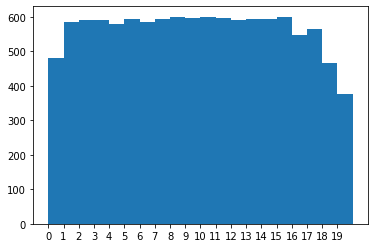

In [12]:
plt.hist(y_ent, bins=[i for i in range(21)])
plt.xticks(np.unique(y_ent))
plt.show()

Obtenemos la representación vectorizada binaria. 

In [10]:
vec = CountVectorizer(max_features=1000,
                      stop_words='english', 
                      binary=True)

X_ent = vec.fit_transform(ng_ent.data)
y_ent = ng_ent.target

X_prueba = vec.transform(ng_prueba.data)
y_prueba = ng_prueba.target

En `scikit-learn` dentro del submódulo `naive_bayes` están definidos clasificadores bayesianos ingenuos con distintas distribuciones para los atributos. Compararemos nuestro clasificador con el `BernoulliNB` de `scikit-learn`.

In [18]:
clasificador = BernoulliNB()
clasificador.fit(X_ent.toarray(), y_ent)
pred = clasificador.predict(X_prueba.toarray())
exactitud = (pred==y_prueba).mean()
print('Exactitud (nuestra) = {0}'.format(exactitud))

skc = SKBNB()
skc = skc.fit(X_ent, y_ent)
skpred = skc.predict(X_prueba.toarray())
exactitudsk = (skpred==y_prueba).mean()
print('Exactitud (sklearn) = {0}'.format(exactitudsk))

Exactitud (nuestra) = 0.5456718003186405
Exactitud (sklearn) = 0.5570897503983006
